In [1]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import time
import warnings
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import time
from transformers import BertForSequenceClassification ,BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from sklearn.metrics import f1_score

from google.colab import drive
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [2]:
drive.mount('/content/drive/')
data = pd.read_csv("/content/drive/My Drive/yelp_review_train.csv")
test_data = pd.read_csv("/content/drive/My Drive/yelp_review_test.csv")

Mounted at /content/drive/


In [3]:
!nvidia-smi

Sat Dec  9 19:20:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

On looking at the data , we just have text and stars which the rating for the said review

In [4]:
data.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


In [5]:
data.isnull().sum(axis = 0)

text     0
stars    0
dtype: int64

In [6]:
classes, counts = np.unique(data['stars'].to_numpy(),return_counts = True)

In [7]:
print('labesls : ',classes)
print('counts : ', counts)

labesls :  [1. 2. 3. 4. 5.]
counts :  [26821 13524 17235 36391 80786]


<Axes: title={'center': 'star rating vs review count'}, xlabel='star ratings', ylabel='review count'>

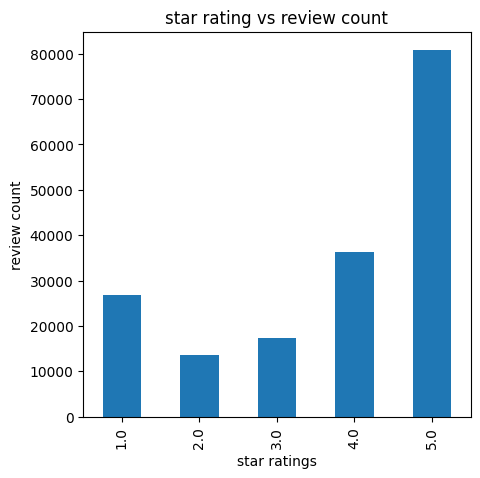

In [8]:
data['stars'].value_counts().sort_index().plot(kind = 'bar',figsize = (5,5), xlabel = 'star ratings',ylabel = 'review count',title = 'star rating vs review count')

Rating: 1.0 stars


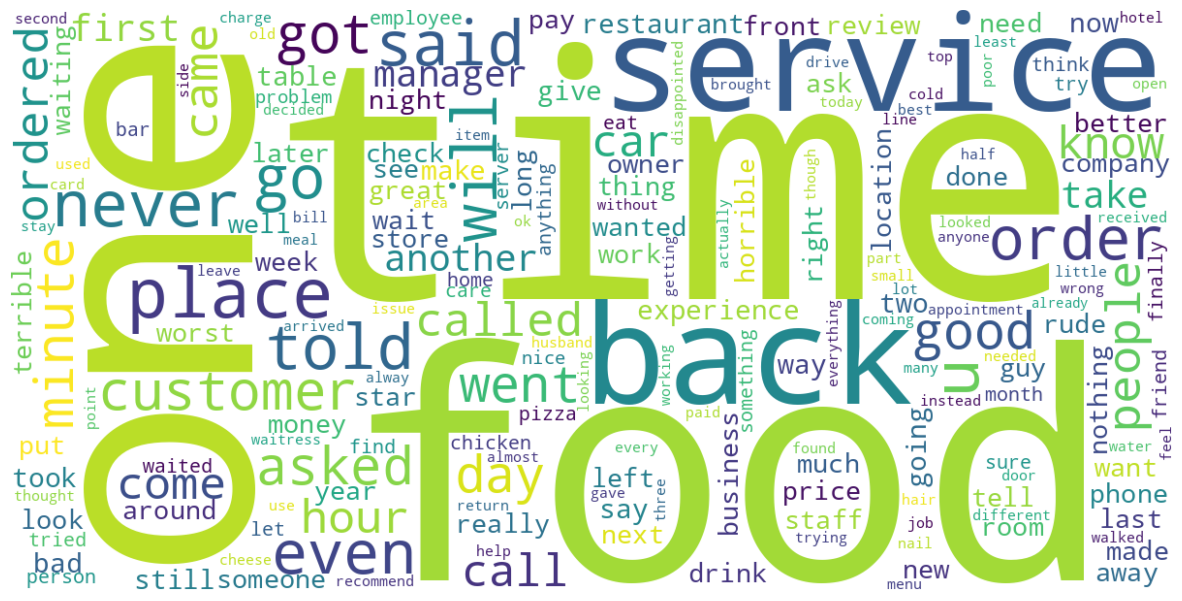

*************************
Rating: 2.0 stars


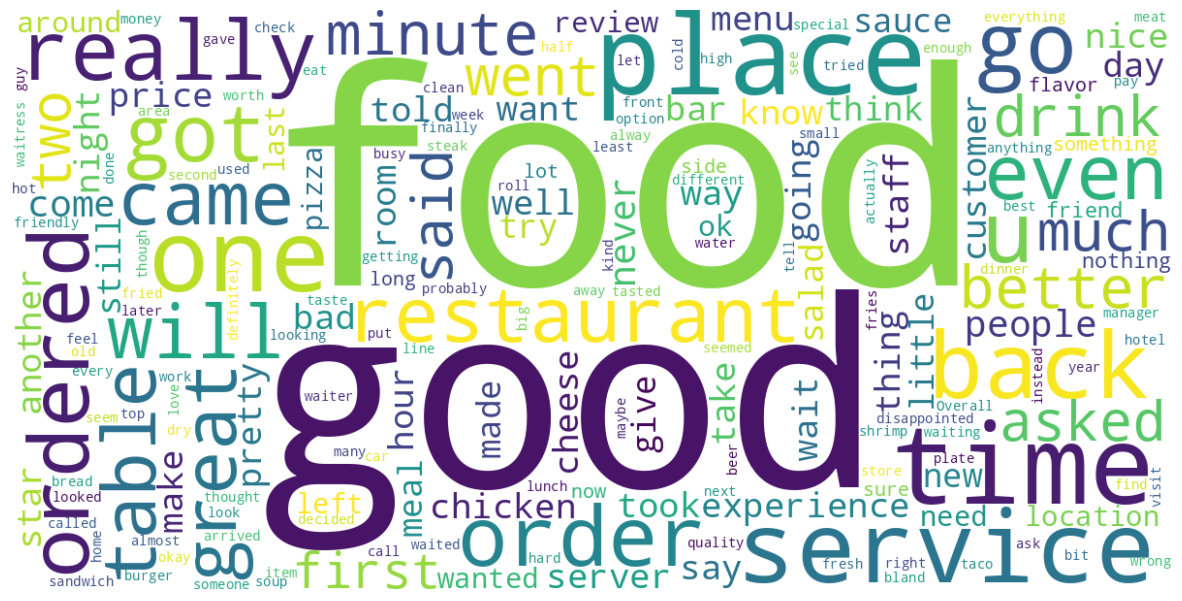

*************************
Rating: 3.0 stars


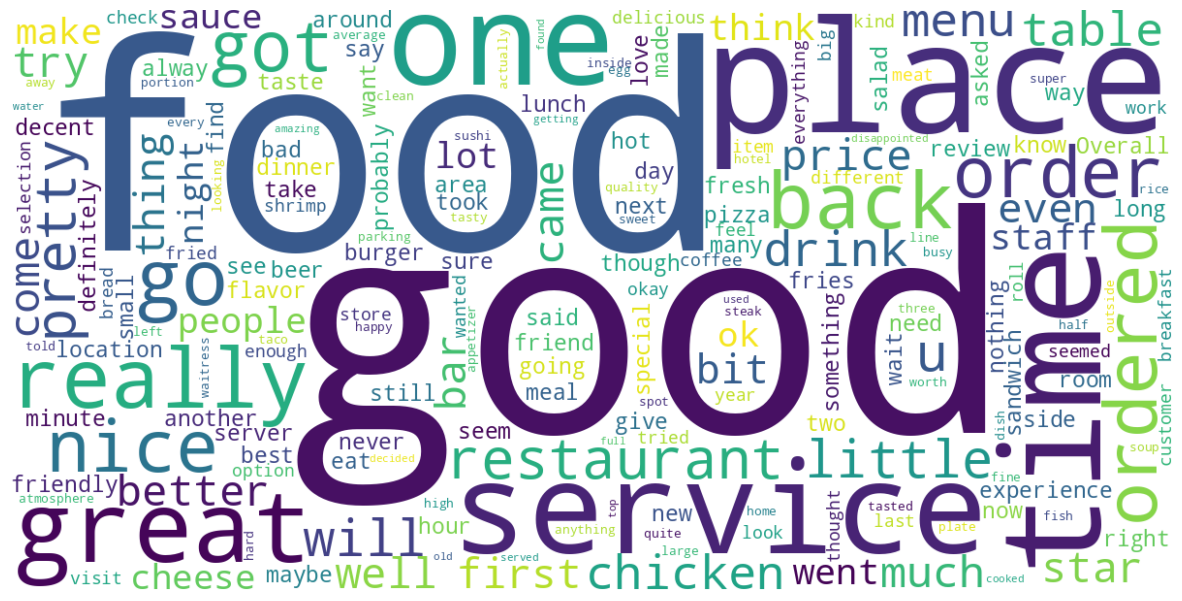

*************************
Rating: 4.0 stars


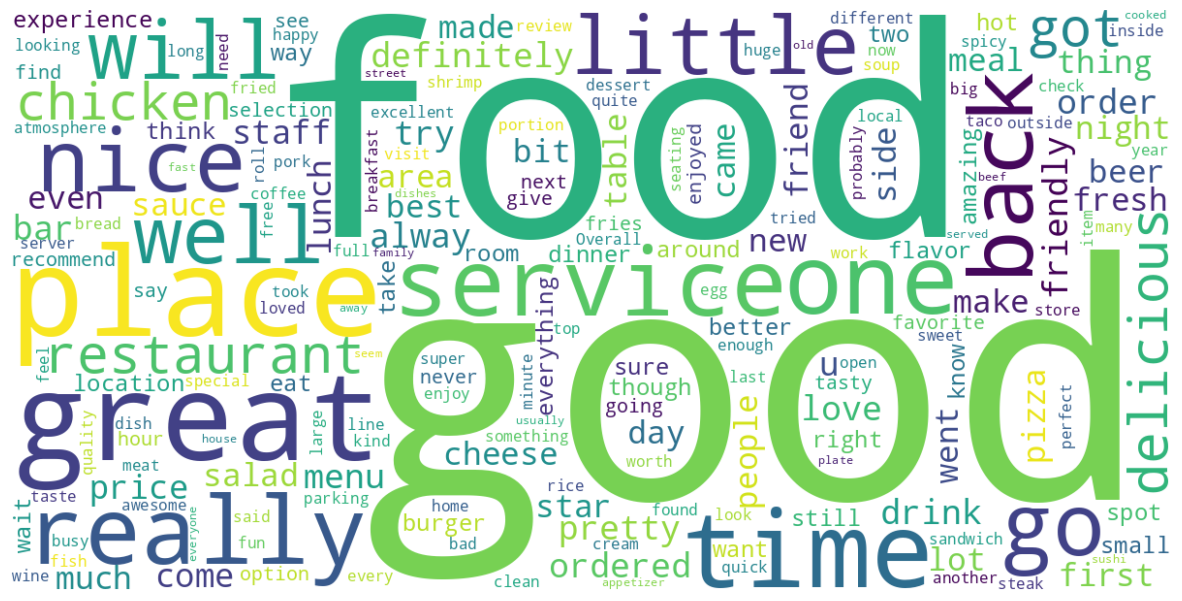

*************************
Rating: 5.0 stars


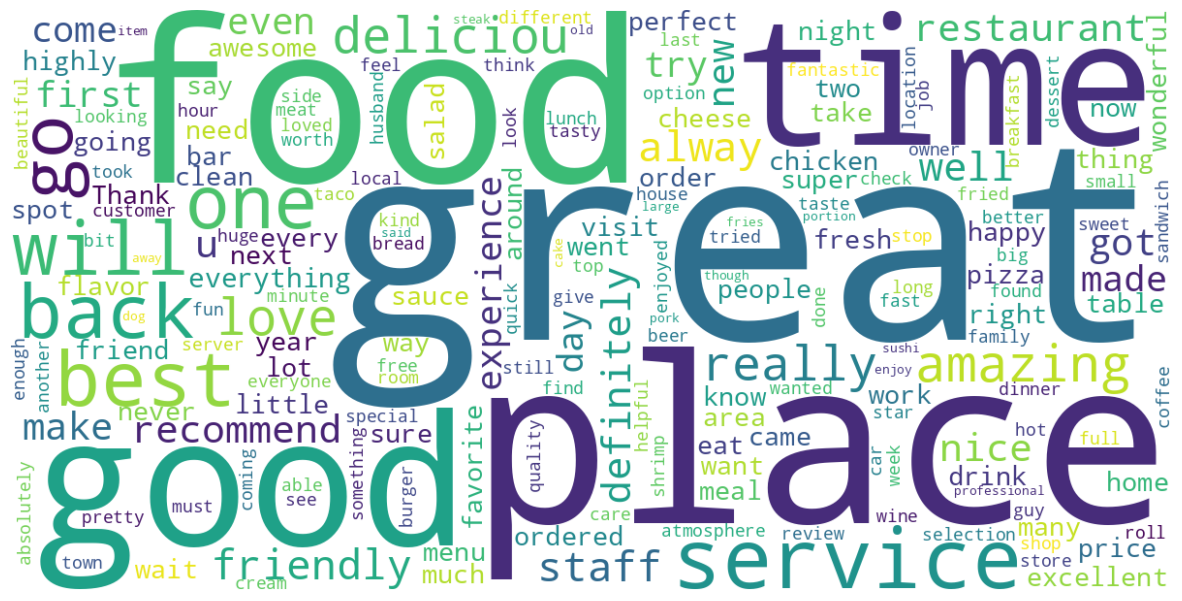

*************************


In [9]:
for rating in sorted(data['stars'].unique()):
    print(f'Rating: {rating} stars')


    text = ' '.join(review for review in data[data['stars'] == rating]['text'].values)

    # WordCloud uses a built-in stopwords list
    wordcloud = WordCloud(collocations=False, background_color='white', width=1200, height=600).generate(text)

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    print('*' * 25)

<Figure size 2000x1500 with 0 Axes>

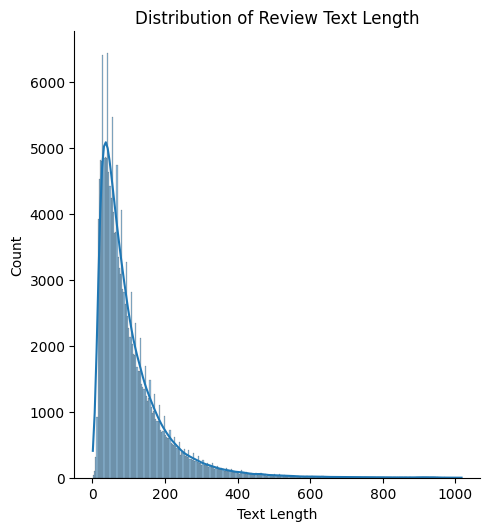

In [10]:
plt.figure(figsize=(20,15))
sns.displot([len(txt.split()) for txt in data['text'].values],kde = True)
plt.title('Distribution of Review Text Length')
plt.xlabel('Text Length')
plt.show()

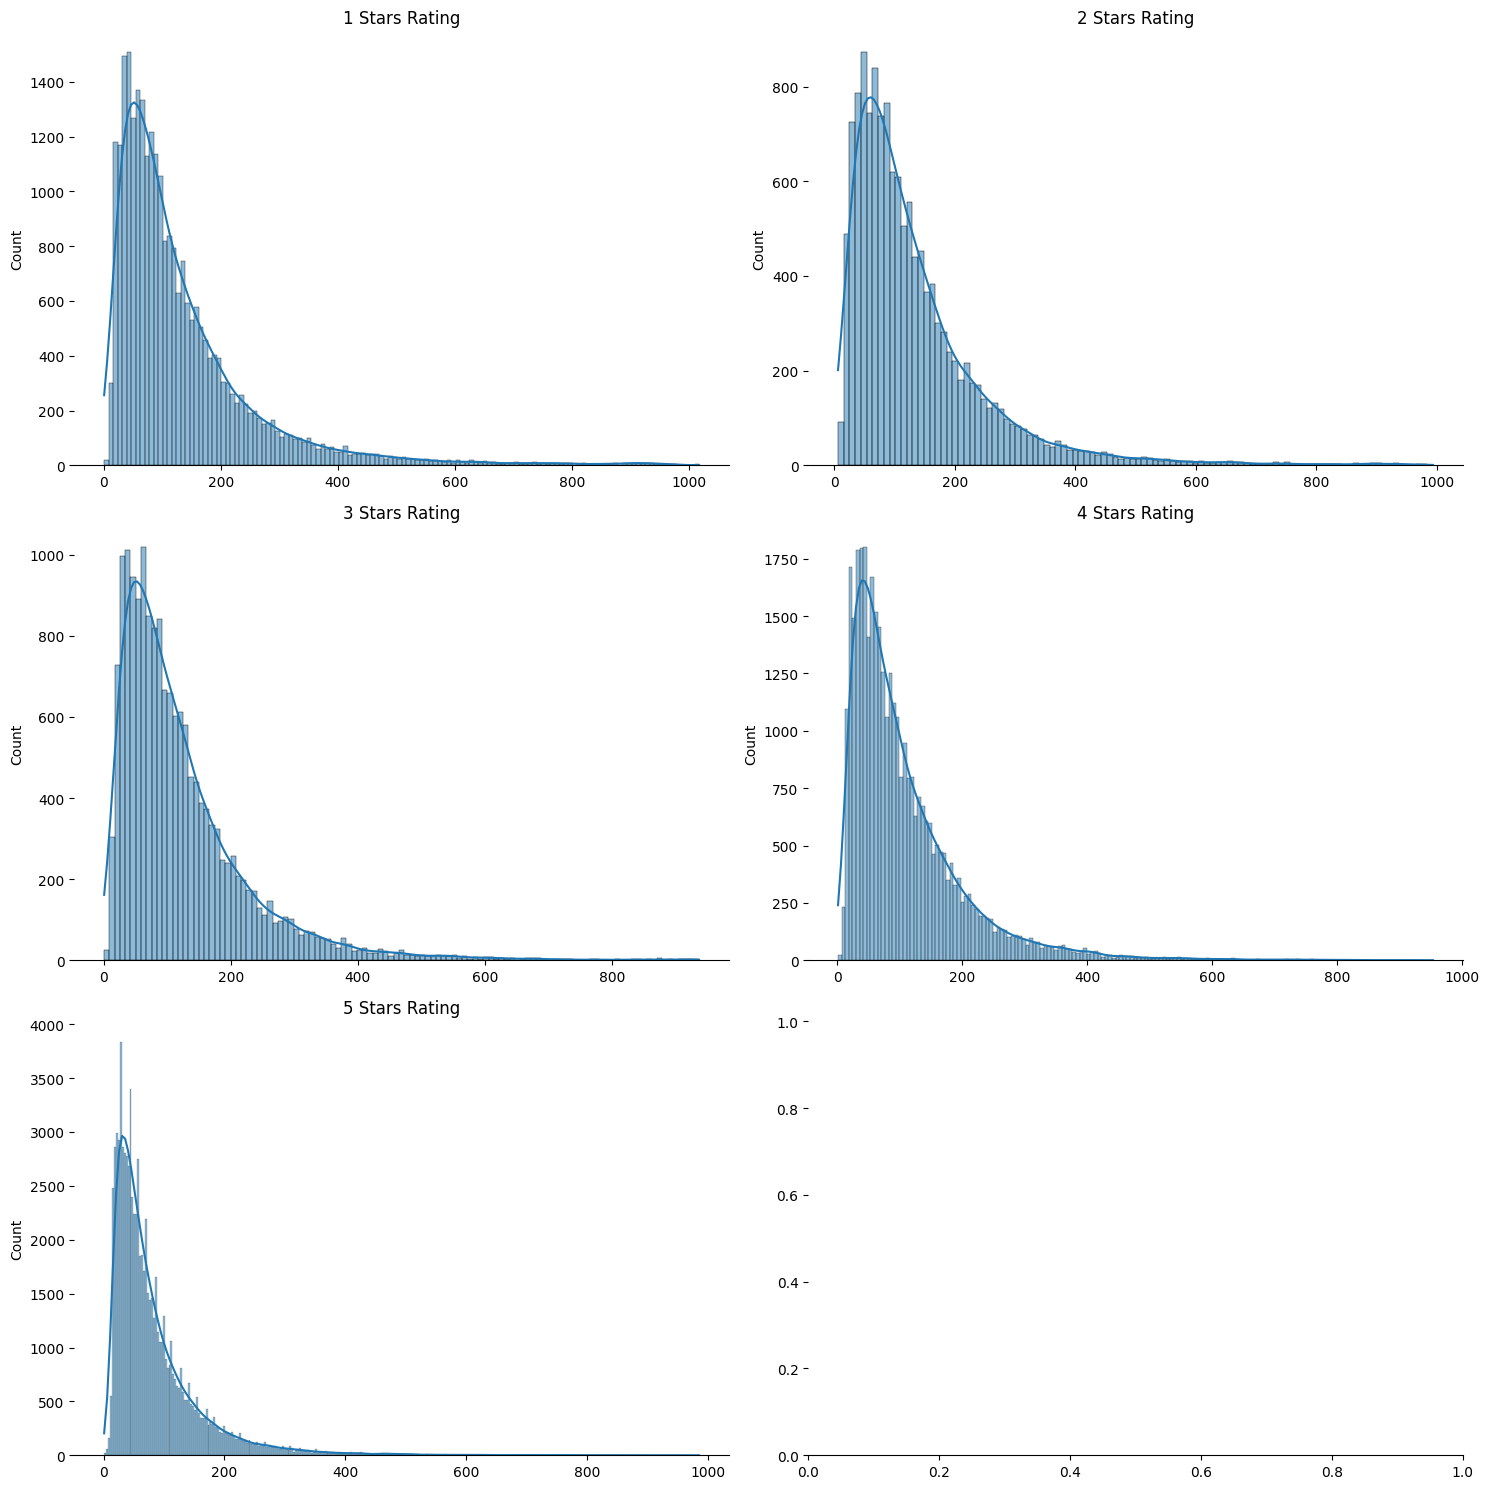

In [11]:
f, axes = plt.subplots(3, 2, figsize=(15,15), sharex=False)
sns.despine(left=True)

#
plot_y = 0
for idx, stars in enumerate([1, 2, 3, 4, 5]):
    plot_x = 0 if idx % 2 == 0 else 1


    sns.histplot(
        [len(txt.split()) for txt in data[data['stars'] == stars]['text'].values],
        kde = True,ax = axes[plot_y, plot_x] )
    axes[plot_y, plot_x].set_title(f'{stars} Stars Rating')
    plot_y += 1 if idx % 2 == 1 else 0

plt.tight_layout()
plt.show()

**Preprocessing Data**

In [12]:
X = data['text']
y = data['stars']
seed = 21
TRAINED_MODEL_NAME = "bert-base-cased"

In [13]:
x_train, x_val , y_train, y_val = train_test_split(X,y,train_size= 0.80,random_state= seed)


In [14]:
tokenizer = BertTokenizer.from_pretrained(TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [107]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(data.text):
  tokens = tokenizer.encode(txt, max_length=512, truncation= True)
  token_lens.append(len(tokens))



100%|██████████| 174757/174757 [08:07<00:00, 358.73it/s]


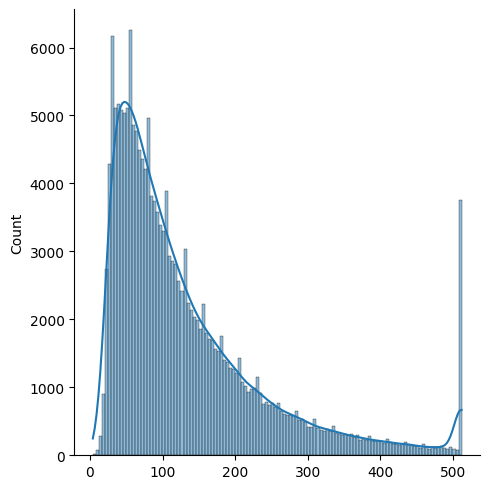

In [108]:
sns.displot(token_lens,kde = True)

In [15]:
MAX_LEN = 120

In [16]:
from torch.utils.data import Dataset, DataLoader
class TokenizeDataset(Dataset):
    def __init__(self,txt,targets,tokenizer,max_len):
        self.reviews = txt
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors='pt',
            )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [17]:
def discriminator(x) :
  if x > 3:
    return 2
  elif x == 3:
    return 1
  else:
    return 0

In [18]:
class_names = ['negative','neutral','positive']

In [19]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_train = list(map(lambda x: discriminator(x), y_train))
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(class_weights_train), y= class_weights_train)
print(class_weights)
print(np.unique(class_weights_train,return_counts= True))

[1.44313349 3.36134353 0.49762055]
(array([0, 1, 2]), array([32292, 13864, 93649]))


In [20]:
class_weights_dataset = list(map(lambda x: discriminator(x), y))
class_weights_set = compute_class_weight(class_weight = "balanced", classes= np.unique(class_weights_dataset), y= class_weights_dataset)
print(class_weights_set)
print(np.unique(class_weights_dataset,return_counts= True))

[1.44385508 3.37988589 0.49713112]
(array([0, 1, 2]), array([ 40345,  17235, 117177]))


In [37]:

def create_data_loader(x,y,tokenizer,max_len,batch_size):
    ds = TokenizeDataset(
        txt = x.to_numpy(),
        targets = np.array(y),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=3)

In [22]:
y_train =list(map(lambda x: discriminator(x), y_train))
y_val = list(map(lambda x: discriminator(x), y_val))

In [23]:
y_test = list(map(lambda x: discriminator(x), test_data['stars']))
x_test = test_data['text']

In [24]:
np.unique(y_train,return_counts= True)
print(x_test.shape)

(13980,)


In [38]:

BATCH_SIZE = 32
train_data_loader = create_data_loader(x_train,y_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(x_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(x_test,y_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Transformer Model**

In [26]:

# Define the device (GPU or CPU) to train the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if device.type == 'cuda':
#     model.cuda()
#     print(f'{torch.cuda.get_device_name(0)} is used...')
# else:
#     print('CPU is used...')

In [27]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False
    )
    #print(pooled_output)
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [28]:
classifier = SentimentClassifier(len(class_names))
classifier = classifier.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [39]:
EPOCHS = 3
optimizer = AdamW(classifier.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


loss_fn = nn.CrossEntropyLoss().to(device)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
def format_elapsed_time(elapsed):
    """
    Convert elapsed time from seconds to hh:mm:ss.s format.

    :param elapsed: float
        Elapsed time in seconds (t_current - t_start).
    :return: string
        Time in human-readable hh:mm:ss.s format, e.g. '04:35:41.05'.
    """

    hours, remainder = divmod(elapsed, 60*60)
    minutes, seconds = divmod(remainder, 60)

    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds)

In [41]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    step = 0
    t_start = time.time()

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)
        # Print out the progress every 25 steps
        if (step + 1) % 100 == 0 and step != 0:
            elapsed_time = format_elapsed_time(time.time() - t_start)
            print(f'\tBatch {step + 1}/{len(train_data_loader)}, elapsed {elapsed_time}')

        step += 1

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [43]:
len(x_train)

139805

In [44]:

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        classifier,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(x_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        classifier,
        val_data_loader,
        loss_fn,
        device,
        len(x_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(classifier.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/3
----------
	Batch 100/4369, elapsed 00:01:00.36
	Batch 200/4369, elapsed 00:02:00.37
	Batch 300/4369, elapsed 00:03:00.26
	Batch 400/4369, elapsed 00:04:00.17
	Batch 500/4369, elapsed 00:05:00.14
	Batch 600/4369, elapsed 00:06:00.03
	Batch 700/4369, elapsed 00:06:59.88
	Batch 800/4369, elapsed 00:07:59.76
	Batch 900/4369, elapsed 00:08:59.66
	Batch 1000/4369, elapsed 00:09:59.53
	Batch 1100/4369, elapsed 00:10:59.36
	Batch 1200/4369, elapsed 00:11:59.16
	Batch 1300/4369, elapsed 00:12:58.98
	Batch 1400/4369, elapsed 00:13:58.90
	Batch 1500/4369, elapsed 00:14:58.80
	Batch 1600/4369, elapsed 00:15:58.67
	Batch 1700/4369, elapsed 00:16:58.59
	Batch 1800/4369, elapsed 00:17:58.53
	Batch 1900/4369, elapsed 00:18:58.46
	Batch 2000/4369, elapsed 00:19:58.36
	Batch 2100/4369, elapsed 00:20:58.32
	Batch 2200/4369, elapsed 00:21:58.21
	Batch 2300/4369, elapsed 00:22:58.14
	Batch 2400/4369, elapsed 00:23:58.09
	Batch 2500/4369, elapsed 00:24:58.08
	Batch 2600/4369, elapsed 00:25:58.03


Running for more than 3 epoch could have been done on colab, but wasn't able possible to run because of gpu restrictions on a free tier account and progress getting  lost if the session becomes un-interactive.

In [101]:

history_train_local = [0]
history_val_local = [0]
for hist in history['train_acc']:
  history_train_local.append(hist.cpu().data.item())

for hist in history['val_acc']:
  history_val_local.append(hist.cpu().data.item())

print('train accuracy : ',history_train_local)
print('val accuracy for each epoch : ',history_val_local)

[0.885719394871428, 0.9187225063481278, 0.943449805085655]
[0.8894483863584344, 0.8909075303273061, 0.8873311970702678]


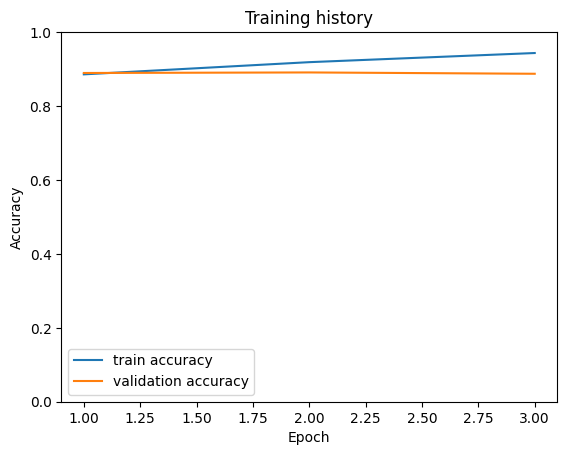

In [112]:

import matplotlib.pyplot as plt

plt.plot(range(1,EPOCHS+1),history_train_local, label='train accuracy')
plt.plot(range(1, EPOCHS+1),history_val_local, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


In [50]:
test_acc, _ = eval_model(
  classifier,
  test_data_loader,
  loss_fn,
  device,
  len(x_test)
)
test_acc.item()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.8888412017167383

In [53]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [54]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  classifier,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [55]:

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.87      0.88      0.88      3145
     neutral       0.56      0.50      0.53      1416
    positive       0.94      0.95      0.94      9419

    accuracy                           0.89     13980
   macro avg       0.79      0.78      0.78     13980
weighted avg       0.88      0.89      0.89     13980



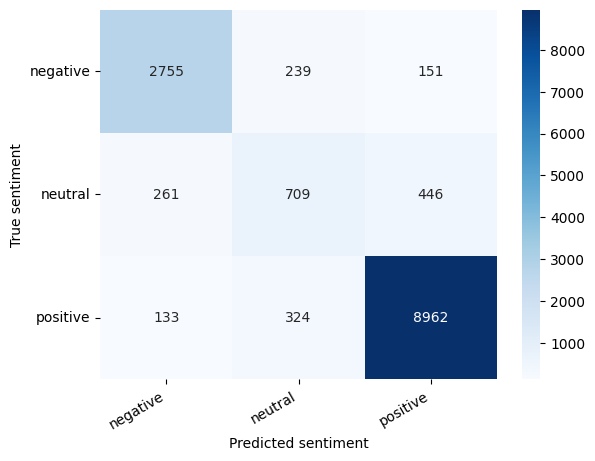

In [56]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [76]:
ex_review_text_pos = "the food was amazing and really  flavourful"

In [78]:
ex_review_text_neu = "the food was good but could be a bit really  flavourful"

In [80]:
ex_review_text_neg = "the food was bad and could be a bit really  flavourful"

In [77]:
encoded_review_pos = tokenizer.encode_plus(
  ex_review_text_pos,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation = True,
  return_attention_mask=True,
  return_tensors='pt',
)


In [81]:
encoded_review_neu = tokenizer.encode_plus(
  ex_review_text_neu,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation = True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [82]:
encoded_review_neg = tokenizer.encode_plus(
  ex_review_text_neg,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation = True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [84]:
input_ids = encoded_review_pos['input_ids'].to(device)
attention_mask = encoded_review_pos['attention_mask'].to(device)
output = classifier(input_ids, attention_mask)
_, prediction_pos = torch.max(output, dim=1)
print(f'Review text: {ex_review_text_pos}')
print(f'Sentiment of review : {class_names[prediction_pos]}')

Review text: the food was amazing and really  flavourful
Sentiment of review : positive


In [85]:
input_ids = encoded_review_neu['input_ids'].to(device)
attention_mask = encoded_review_neu['attention_mask'].to(device)
output = classifier(input_ids, attention_mask)
_, prediction_neu = torch.max(output, dim=1)
print(f'Review text: {ex_review_text_neu}')
print(f'Sentiment of review : {class_names[prediction_neu]}')

Review text: the food was good but could be a bit really  flavourful
Sentiment of review : neutral


In [86]:
input_ids = encoded_review_neg['input_ids'].to(device)
attention_mask = encoded_review_neg['attention_mask'].to(device)
output = classifier(input_ids, attention_mask)
_, prediction_neg = torch.max(output, dim=1)
print(f'Review text: {ex_review_text_neg}')
print(f'Sentiment of review : {class_names[prediction_neg]}')

Review text: the food was bad and could be a bit really  flavourful
Sentiment of review : negative
